In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from matplotlib import pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tashfiq-vai-datasetdigit-recognizer/Train_Labels.npy
/kaggle/input/tashfiq-vai-datasetdigit-recognizer/Train_Images.npy
/kaggle/input/tashfiq-vai-datasetdigit-recognizer/Train_Images(1).npy
/kaggle/input/tashfiq-vai-datasetdigit-recognizer/clean_Labels.npy
/kaggle/input/tashfiq-vai-datasetdigit-recognizer/Train_Labels(1).npy
/kaggle/input/tashfiq-vai-datasetdigit-recognizer/clean_Images.npy


In [2]:
#pytorch utility imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [3]:
#import external libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import math
%matplotlib inline

In [4]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

True
True
cuda


In [5]:
train_labels = np.load('../input/tashfiq-vai-datasetdigit-recognizer/Train_Labels.npy')
train_images = (np.load('../input/tashfiq-vai-datasetdigit-recognizer/Train_Images.npy')).astype('float32')
# test_images = (test_df.iloc[:,:].values).astype('float32')



In [6]:
train_images.shape

(23502, 150, 150)

In [7]:
#Training and Validation Split
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,
                                                                     stratify=train_labels, random_state=123,
                                                                     test_size=0.20)

In [8]:
val_images.shape

(4701, 150, 150)

In [9]:
train_images.shape

(18801, 150, 150)

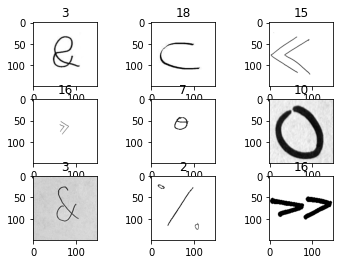

In [10]:
#train samples
for i in range(0, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(train_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])

In [11]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(train_labels)
train_labels_tensor=train_labels_tensor.type(torch.LongTensor)
# Yt_train.type(torch.LongTensor)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

#val
val_images_tensor = torch.tensor(val_images)/255.0
val_labels_tensor = torch.tensor(val_labels)
val_labels_tensor=val_labels_tensor.type(torch.LongTensor)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)

# #test
# test_images_tensor = torch.tensor(test_images)/255.0

In [12]:
train_images_tensor.shape

torch.Size([18801, 150, 150])

In [13]:
train_loader = DataLoader(train_tensor, batch_size=32, num_workers=2, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=32, num_workers=2, shuffle=True)
# test_loader = DataLoader(test_images_tensor, batch_size=16, num_workers=2, shuffle=False)

In [14]:
train_loader

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


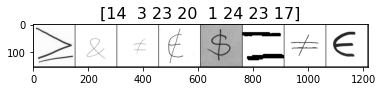

In [15]:
for batch_idx, (data, target) in enumerate(train_loader):
    img_grid = make_grid(data[0:8,].unsqueeze(1), nrow=8)
    img_target_labels = target[0:8,].numpy()
    break
    
plt.imshow(img_grid.numpy().transpose((1,2,0)))
plt.rcParams['figure.figsize'] = (10, 2)
plt.title(img_target_labels, size=16)
plt.show()

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
#             nn.Flatten(),
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
#             nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(128*37*37, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 25) #24 classes
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        
        x = self.linear_block(x)
        
        return x

In [17]:
conv_model = Net()
conv_model

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=175232, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [18]:
optimizer = optim.Adam(params=conv_model.parameters(), lr=0.003) #0.003
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    conv_model = conv_model.cuda()
    criterion = criterion.cuda()

In [19]:
def train_model(num_epoch):
    conv_model.train()
    exp_lr_scheduler.step()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        optimizer.zero_grad()
        output = conv_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                num_epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data))
            
def evaluate(data_loader):
    conv_model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = conv_model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).data

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

In [20]:
num_epochs = 100

for n in range(num_epochs):
    train_model(n)
    evaluate(val_loader)

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Epoch: 0 [3200/18801 (17%)]	Loss: 2.833461
Train Epoch: 0 [6400/18801 (34%)]	Loss: 2.462476
Train Epoch: 0 [9600/18801 (51%)]	Loss: 1.885303
Train Epoch: 0 [12800/18801 (68%)]	Loss: 1.714803
Train Epoch: 0 [16000/18801 (85%)]	Loss: 1.529114


/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Val Loss: 1.4944, Val Accuracy: 2533/4701 (53.882%)

Train Epoch: 1 [3200/18801 (17%)]	Loss: 1.207943
Train Epoch: 1 [6400/18801 (34%)]	Loss: 1.217408
Train Epoch: 1 [9600/18801 (51%)]	Loss: 1.171993
Train Epoch: 1 [12800/18801 (68%)]	Loss: 0.983717
Train Epoch: 1 [16000/18801 (85%)]	Loss: 1.337664

Average Val Loss: 0.6741, Val Accuracy: 3799/4701 (80.813%)

Train Epoch: 2 [3200/18801 (17%)]	Loss: 1.321274
Train Epoch: 2 [6400/18801 (34%)]	Loss: 0.965527
Train Epoch: 2 [9600/18801 (51%)]	Loss: 0.982389
Train Epoch: 2 [12800/18801 (68%)]	Loss: 0.774650
Train Epoch: 2 [16000/18801 (85%)]	Loss: 1.021984

Average Val Loss: 0.6830, Val Accuracy: 3789/4701 (80.600%)

Train Epoch: 3 [3200/18801 (17%)]	Loss: 0.934967
Train Epoch: 3 [6400/18801 (34%)]	Loss: 0.843192
Train Epoch: 3 [9600/18801 (51%)]	Loss: 0.787875
Train Epoch: 3 [12800/18801 (68%)]	Loss: 0.809713
Train Epoch: 3 [16000/18801 (85%)]	Loss: 0.903109

Average Val Loss: 0.4930, Val Accuracy: 3936/4701 (83.727%)

Train Epoch

In [21]:
# def make_predictions(data_loader):
#     conv_model.eval()
#     test_preds = torch.LongTensor()
    
#     for i, data in enumerate(data_loader):
#         data = data.unsqueeze(1)
        
#         if torch.cuda.is_available():
#             data = data.cuda()
            
#         output = conv_model(data)
        
#         preds = output.cpu().data.max(1, keepdim=True)[1]
#         test_preds = torch.cat((test_preds, preds), dim=0)
        
#     return test_preds